# Replication for results in Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

In [1]:
# !pip install vaderSentiment
# !pip install textstat
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# # !pip install simpletransformers
# !pip install imblearn
# !pip install torch
# !pip install tensorflow
# !pip install tensorflow_hub
# !pip install tensorflow-text
# !pip install gensim

In [2]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim
import nltk
from nltk.stem.porter import *
import string
import re
import pickle
import time

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import transformers as ppb
import torch
import swifter

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification


# For GloVe

from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Loading the data

In [3]:
df = pd.read_csv("labeled_data.csv", index_col=0)

In [4]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
df.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


In [6]:
df.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


<AxesSubplot:>

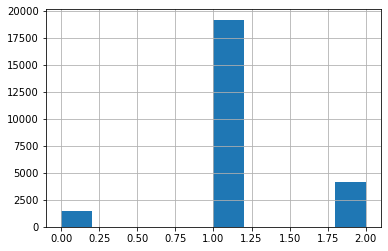

In [7]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

To make our problem more simpler and to get better results overall, we will convert this multi-class into binary class, i.e., we will combine hate and offensive into one category "hate" whereas we will keep the third category "Neither" as same. This approach will also balance both the classes a bit, but this still remains an imbalanced classification overall.

In [8]:
df['class'] = df['class'].replace([1,2], [0,1])

As seen from the results below, we have imbalanced classes.

In [9]:
df['class'].value_counts()

0    20620
1     4163
Name: class, dtype: int64

In [10]:
# Making dataframe copies to use in future.
df_bert = df.copy()
df_glove = df.copy()
df_w2v = df.copy()

In [26]:
tweets=df.tweet

## Data Preprocessing

In [11]:
# Function for text prperocessing

def clean_text(text):
    '''Remove stopwords, make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    
    stopwords = nltk.corpus.stopwords.words("english")

    other_exclusions = ["#ff", "ff", "rt"]
    stopwords.extend(other_exclusions)
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'\
                  '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('@[\w\-]+', '', text)
    text = re.sub(r'\brt\b\s+',"", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
#     tokens = word_tokenize(text)

#     text = [t for t in tokens if not t in stopwords]
    
    return text


def remove_stopwords(text):
    removed = []
    stop_words = nltk.corpus.stopwords.words("english")
    other_exclusions = ["#ff", "ff", "rt"]
    stop_words.extend(other_exclusions)
    stopwords = list(stop_words)
    
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

In [12]:
# nltk.download('stopwords')

In [13]:
df['tweet'] = df['tweet'].apply(lambda x: clean_text(x))

In [14]:
# nltk.download('punkt')

In [15]:
df['tweet'] = df['tweet'].apply(lambda x: remove_stopwords(x))

In [16]:
df['tweet'] = df['tweet'].apply(lambda x: remove_extra_white_spaces(x))

In [17]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [18]:
df['tweet'] = df['tweet'].apply(lambda x: lemmatizing(x))

In [19]:
X = df['tweet']
y = df['class']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, stratify=y,  test_size=0.30)

# Using TFIDF Vectorizer

In [21]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

TfidfVectorizer()

In [22]:
X_train_tf = vectorizer.transform(X_train)
X_train_tf = X_train_tf.toarray()

X_test_tf = vectorizer.transform(X_test)
X_test_tf = X_test_tf.toarray()

## Creating Models for TFIDF Vectorizer

### 1) SGD Classifier

In [23]:
start_time = time.time()

sgd1 = SGDClassifier()

sgd1.fit(X_train_tf, y_train)

print("Processing Time:" , (time.time() - start_time))

Processing Time: 21.040452003479004


In [24]:
sgd1_pred = sgd1.predict(X_test_tf)

accuracy_sgd1 = accuracy_score(y_test, sgd1_pred)

print(classification_report(y_test, sgd1_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6186
           1       0.86      0.83      0.84      1249

    accuracy                           0.95      7435
   macro avg       0.91      0.90      0.91      7435
weighted avg       0.95      0.95      0.95      7435



### 2) Random Forest Classifier

In [25]:
start_time = time.time()

rfc1 = RandomForestClassifier()

rfc1.fit(X_train_tf, y_train)

print("Processing Time:" , (time.time() - start_time))

Processing Time: 341.8051929473877


In [42]:
rfc1_pred = rfc1.predict(X_test_tf)

accuracy_rfc1 = accuracy_score(y_test, rfc1_pred)

print(classification_report(y_test, rfc1_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6186
           1       0.88      0.77      0.82      1249

    accuracy                           0.94      7435
   macro avg       0.92      0.88      0.89      7435
weighted avg       0.94      0.94      0.94      7435



### 3) Logistic Regression

In [26]:
start_time = time.time()

lr1 = LogisticRegression(multi_class='multinomial', solver='lbfgs', \
                        class_weight='balanced', penalty="l2", C=0.01)

lr1.fit(X_train_tf, y_train)

print("Processing Time:" , (time.time() - start_time))

Processing Time: 11.106944799423218


In [44]:
lr1_pred = lr1.predict(X_test_tf)

accuracy_lr1 = accuracy_score(y_test, lr1_pred)
print(classification_report(y_test, lr1_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      6186
           1       0.60      0.98      0.74      1249

    accuracy                           0.89      7435
   macro avg       0.80      0.92      0.83      7435
weighted avg       0.93      0.89      0.90      7435



# Using BERT

In [100]:
# !pip install transformers

In [98]:
df_bert.head()

,tweet,class
0,as a woman you shouldnt complain about clean...,1
1,boy dats coldtyga dwn bad for cuffin dat hoe...,0
2,dawg you ever fuck a bitch and she start to ...,0
3,she look like a tranny,0
4,the shit you hear about me might be true or ...,0


In [90]:
def clean_text(text):
    '''Remove stopwords, make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    
    stopwords = nltk.corpus.stopwords.words("english")

    other_exclusions = ["#ff", "ff", "rt"]
    stopwords.extend(other_exclusions)
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'\
                  '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('@[\w\-]+', '', text)
    text = re.sub(r'\brt\b\s+',"", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


In [91]:
df_bert['tweet'] = df_bert['tweet'].apply(lambda x: clean_text(x))

In [92]:
df_bert = df_bert[['tweet', 'class']]
df_bert.head()

,tweet,class
0,as a woman you shouldnt complain about clean...,1
1,boy dats coldtyga dwn bad for cuffin dat hoe...,0
2,dawg you ever fuck a bitch and she start to ...,0
3,she look like a tranny,0
4,the shit you hear about me might be true or ...,0


In [93]:
X = df_bert['tweet']
y = df_bert['class']

In [94]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [95]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X, y, stratify=y, test_size = 0.30, random_state=42)

In [99]:
class BertTokenizer(object):

    def __init__(self, text=[]):
        self.text = text

        # For DistilBERT:
        self.model_class, self.tokenizer_class, self.pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

        # Load pretrained model/tokenizer
        self.tokenizer = self.tokenizer_class.from_pretrained(self.pretrained_weights)

        self.model = self.model_class.from_pretrained(self.pretrained_weights)

    def get(self):

        df = pd.DataFrame(data={"text":self.text})
        tokenized = df["text"].apply((lambda x: self.tokenizer.encode(x, add_special_tokens=True)))

        max_len = 0
        for i in tokenized.values:
            if len(i) > max_len:
                max_len = len(i)

        padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

        attention_mask = np.where(padded != 0, 1, 0)
        input_ids = torch.tensor(padded)
        attention_mask = torch.tensor(attention_mask)

        with torch.no_grad(): last_hidden_states = self.model(input_ids, attention_mask=attention_mask)
        
        features = last_hidden_states[0][:, 0, :].numpy()

        return features

In [97]:
_instance =BertTokenizer(text=X_train_bert)
tokens = _instance.get()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2824531968 bytes.

## Creating Models for BERT

### 1) Logistic Regression

In [ ]:
start_time = time.time()

lr2 = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr2.fit(tokens, y_train_bert)

print("Processing Time:" , (time.time() - start_time))

In [ ]:
_instance = BertTokenizer(text=X_test_bert)
tokensTest = _instance.get()

In [ ]:
lr2_pred = lr2.predict(tokensTest)

In [ ]:
accuracy_lr2 = accuracy_score(y_test_bert, lr2_pred)

print(classification_report(y_test_bert, lr2_pred))

### 2) SGD Classifier

In [ ]:
start_time = time.time()

sgd2 = SGDClassifier()
sgd2.fit(tokens, y_train_bert)

print("Processing Time:" , (time.time() - start_time))

In [ ]:
sgd2_pred = sgd2.predict(tokensTest)

accuracy_sgd2 = accuracy_score(y_test_bert, sgd2_pred)

print(classification_report(y_test_bert, sgd2_pred))

### 3) Random Forest Classifier

In [ ]:
start_time = time.time()


rfc2 = RandomForestClassifier()
rfc2.fit(tokens, y_train_bert)

print("Processing Time:" , (time.time() - start_time))

In [ ]:
rfc2_pred = rfc2.predict(tokensTest)

accuracy_rfc2 = accuracy_score(y_test_bert, rfc2_pred)

print(classification_report(y_test_bert, rfc2_pred))

# Using Word2Vec

In [27]:
df_w2v.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,1,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [28]:
df_w2v['tweet'] = df_w2v['tweet'].apply(lambda x: clean_text(x))

In [29]:
# Clean data using the built in cleaner in gensim
df_w2v['text_clean'] = df_w2v['tweet'].apply(lambda x: gensim.utils.simple_preprocess(x))
df_w2v.head()

,count,hate_speech,offensive_language,neither,class,tweet,text_clean
0,3,0,0,3,1,as a woman you shouldnt complain about clean...,"[as, woman, you, shouldnt, complain, about, cl..."
1,3,0,3,0,0,boy dats coldtyga dwn bad for cuffin dat hoe...,"[boy, dats, coldtyga, dwn, bad, for, cuffin, d..."
2,3,0,3,0,0,dawg you ever fuck a bitch and she start to ...,"[dawg, you, ever, fuck, bitch, and, she, start..."
3,3,0,2,1,0,she look like a tranny,"[she, look, like, tranny]"
4,6,0,6,0,0,the shit you hear about me might be true or ...,"[the, shit, you, hear, about, me, might, be, t..."


In [30]:
X = df_w2v['text_clean']
y = df_w2v['class']

In [31]:
# Split data into train and test sets
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split (X, y , stratify=y, test_size=0.2)

In [32]:
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train_w2v,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

In [33]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train_w2v])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test_w2v])

C:\Users\syed brother\AppData\Local\Temp\ipykernel_11444\2131241061.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
C:\Users\syed brother\AppData\Local\Temp\ipykernel_11444\2131241061.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


In [34]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

## Creating Models for Word2Vec

### 1) logistic Regression

In [35]:
start_time = time.time()

lr3 = LogisticRegression(solver='lbfgs', max_iter=1000) 

# training the model 
lr3.fit(X_train_vect_avg, y_train_w2v.values.ravel())

print("Processing Time:" , (time.time() - start_time))

Processing Time: 0.8392524719238281


In [84]:
lr3_pred = lr3.predict(X_test_vect_avg)

accuracy_lr3 = accuracy_score(y_test_w2v, lr3_pred)

print(classification_report(y_test_w2v, lr3_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      4124
           1       0.57      0.12      0.20       833

    accuracy                           0.84      4957
   macro avg       0.71      0.55      0.55      4957
weighted avg       0.80      0.84      0.79      4957



### 2) SGD

In [36]:
start_time = time.time()

sgd3 = SGDClassifier()

# training the model 
sgd3.fit(X_train_vect_avg, y_train_w2v.values.ravel())

print("Processing Time:" , (time.time() - start_time))

Processing Time: 1.320072889328003


In [86]:
sgd3_pred = sgd3.predict(X_test_vect_avg)

accuracy_sgd3 = accuracy_score(y_test_w2v, sgd3_pred)

print(classification_report(y_test_w2v, sgd3_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      4124
           1       0.00      0.00      0.00       833

    accuracy                           0.83      4957
   macro avg       0.42      0.50      0.45      4957
weighted avg       0.69      0.83      0.76      4957



### 3) Random Forest

In [38]:
start_time = time.time()

rfc3 = RandomForestClassifier()
rfc3 = rfc3.fit(X_train_vect_avg, y_train_w2v.values.ravel())

print("Processing Time:" , (time.time() - start_time))

Processing Time: 16.699248790740967


In [80]:
rfc3_pred = rfc3.predict(X_test_vect_avg)

accuracy_rfc3 = accuracy_score(y_test_w2v, rfc3_pred)

print(classification_report(y_test_w2v, rfc3_pred))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      4124
           1       0.70      0.08      0.15       833

    accuracy                           0.84      4957
   macro avg       0.77      0.54      0.53      4957
weighted avg       0.82      0.84      0.78      4957



# Using GloVe

In [39]:
# Function for text prperocessing

def clean_text(text):
    '''Remove stopwords, make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    
    stopwords = nltk.corpus.stopwords.words("english")

    other_exclusions = ["#ff", "ff", "rt"]
    stopwords.extend(other_exclusions)
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'\
                  '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('@[\w\-]+', '', text)
    text = re.sub(r'\brt\b\s+',"", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
#     tokens = word_tokenize(text)

#     text = [t for t in tokens if not t in stopwords]
    
    return text

In [40]:
df_glove['tweet'] = df_glove['tweet'].apply(lambda x: clean_text(x))

In [41]:
df_glove.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,1,as a woman you shouldnt complain about clean...
1,3,0,3,0,0,boy dats coldtyga dwn bad for cuffin dat hoe...
2,3,0,3,0,0,dawg you ever fuck a bitch and she start to ...
3,3,0,2,1,0,she look like a tranny
4,6,0,6,0,0,the shit you hear about me might be true or ...


In [42]:
df_glove['tokens'] = df_glove['tweet'].map(lambda x: word_tokenize(x))    

df_glove.head()

,count,hate_speech,offensive_language,neither,class,tweet,tokens
0,3,0,0,3,1,as a woman you shouldnt complain about clean...,"[as, a, woman, you, shouldnt, complain, about,..."
1,3,0,3,0,0,boy dats coldtyga dwn bad for cuffin dat hoe...,"[boy, dats, coldtyga, dwn, bad, for, cuffin, d..."
2,3,0,3,0,0,dawg you ever fuck a bitch and she start to ...,"[dawg, you, ever, fuck, a, bitch, and, she, st..."
3,3,0,2,1,0,she look like a tranny,"[she, look, like, a, tranny]"
4,6,0,6,0,0,the shit you hear about me might be true or ...,"[the, shit, you, hear, about, me, might, be, t..."


In [43]:
# Get Labeled tweets vocabulary
# put all tokens of each tweet in one set
total_vocabulary = set(word for tweet in df_glove.tokens for word in tweet)

len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(
    len(total_vocabulary)))

There are 21439 unique tokens in the dataset.


In [44]:
# Get 100d GloVe embeddings for each word present in the vocabulary

glove = {}
with open(r'glove.twitter.27B.100d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [45]:
# Check length of glove dictionary relative to total words

print(f'{len(glove)} of {len(total_vocabulary)} \
    tokens in dataset matched in GloVe and vectorized!')

17362 of 21439     tokens in dataset matched in GloVe and vectorized!


In [46]:
class W2vVectorizer(object):
    """Class to generate mean word embeddings from word vectors. This class is
    quoted from Flatiron School Curriculum Learn.co Mod 4 appendix"""
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, 
    # it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        # X should be a series of lists of tokens
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [47]:
# Instantiate a mean word embedding vectorizer using glove embeddings

vectorizer = W2vVectorizer(glove)

In [48]:
# Use vectorizer to transform tokenized data to vectors

X_glove = vectorizer.transform(df_glove.tokens)

In [49]:
X_glove.shape

(24783, 100)

In [50]:
# Get corresponding y

y.shape

(24783,)

In [51]:
# Perform train test split on data

X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, y,
                                                            stratify=y,
                                                            test_size=0.30, 
                                                            random_state=1)

## Creating Models for Glove

### 1) Logistic Regression

In [54]:
start_time = time.time()

lr4 = LogisticRegression(solver='lbfgs') 

# training the model 
lr4.fit(X_train_glove, y_train_glove)

print("Processing Time:" , (time.time() - start_time))

Processing Time: 0.2528531551361084


In [53]:
lr4_pred = lr4.predict(X_test_glove) # predicting on the validation set 

accuracy_lr4 = accuracy_score(y_test_glove, lr4_pred)

print(classification_report(y_test_glove, lr4_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6186
           1       0.79      0.69      0.74      1249

    accuracy                           0.92      7435
   macro avg       0.87      0.83      0.84      7435
weighted avg       0.91      0.92      0.92      7435



### SGD

In [55]:
start_time = time.time()

sgd4 = SGDClassifier()

# training the model 
sgd4.fit(X_train_glove, y_train_glove)

print("Processing Time:" , (time.time() - start_time))

Processing Time: 0.1949005126953125


In [62]:
sgd4_pred = sgd4.predict(X_test_glove) # predicting on the validation set 

accuracy_sgd4 = accuracy_score(y_test_glove, sgd4_pred)

print(classification_report(y_test_glove, sgd4_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6186
           1       0.79      0.71      0.75      1249

    accuracy                           0.92      7435
   macro avg       0.87      0.83      0.85      7435
weighted avg       0.92      0.92      0.92      7435



### Random Forest

In [56]:
start_time = time.time()

rfc4 = RandomForestClassifier()

rfc4.fit(X_train_glove, y_train_glove)

print("Processing Time:" , (time.time() - start_time))

Processing Time: 19.615691900253296


In [64]:
rfc4_pred = rfc4.predict(X_test_glove) # predicting on the validation set 

accuracy_rfc4 = accuracy_score(y_test_glove, rfc4_pred)

print(classification_report(y_test_glove, rfc4_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      6186
           1       0.82      0.58      0.68      1249

    accuracy                           0.91      7435
   macro avg       0.87      0.78      0.81      7435
weighted avg       0.90      0.91      0.90      7435



# Evaluating Results:

### 1) Results from TFIDF Vectorizer:

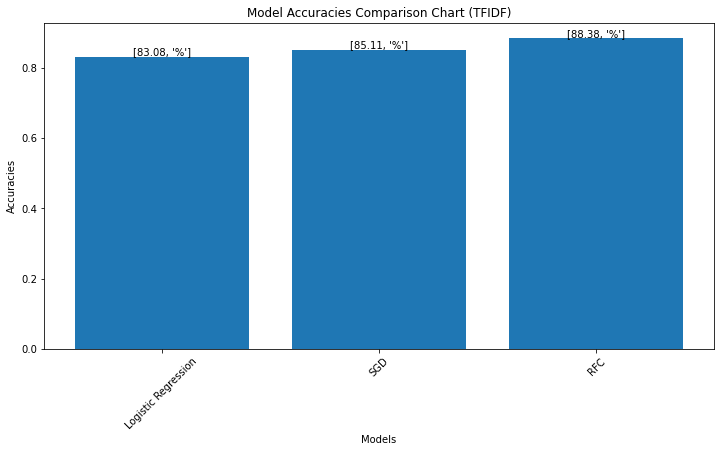

In [57]:
# Visualizing Model Accuracies

fig, ax = plt.subplots(figsize=(12,6))

models = ["Logistic Regression", "SGD", "RFC"]

accuracies1 = [accuracy_lr1, accuracy_sgd1, accuracy_rfc1]
ax.bar(models, accuracies1)
plt.xticks(rotation=45)
plt.title("Model Accuracies Comparison Chart (TFIDF)")
plt.xlabel("Models")
plt.ylabel("Accuracies")
for i in range(len(models)):
    ax.text(i, accuracies1[i], [(accuracies1[i]*100).round(2), "%"], ha="center", va="bottom")
plt.rcParams.update({'font.size': 14})
plt.show()

### 2) Results from BERT

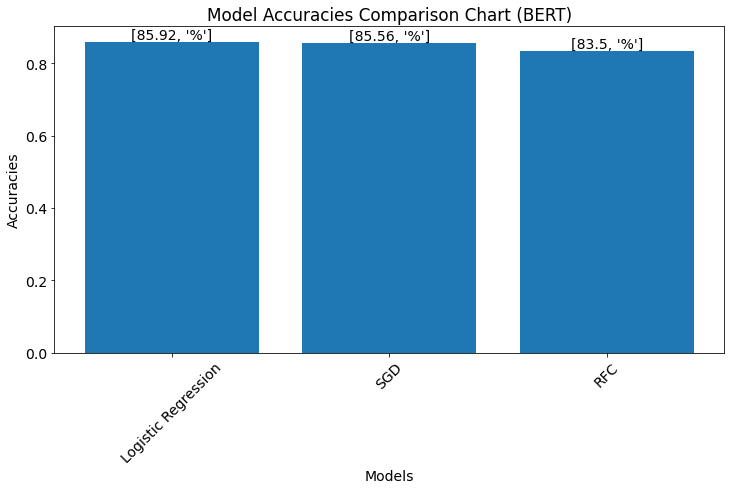

In [99]:
# Visualizing Model Accuracies

fig, ax = plt.subplots(figsize=(12,6))

models = ["Logistic Regression", "SGD", "RFC"]

accuracies2 = [accuracy_lr2, accuracy_sgd2, accuracy_rfc2]
ax.bar(models, accuracies2)
plt.xticks(rotation=45)
plt.title("Model Accuracies Comparison Chart (BERT)")
plt.xlabel("Models")
plt.ylabel("Accuracies")
for i in range(len(models)):
    ax.text(i, accuracies2[i], [(accuracies2[i]*100).round(2), "%"], ha="center", va="bottom")
plt.rcParams.update({'font.size': 14})
plt.show()

### 3) Results from Word2Vec

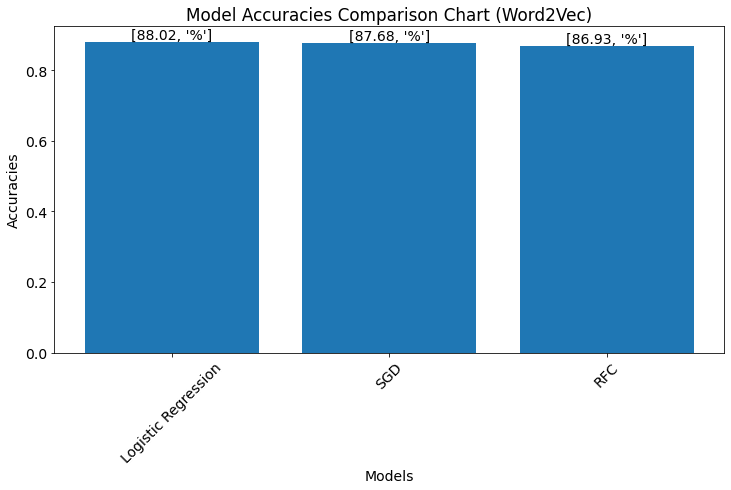

In [98]:
# Visualizing Model Accuracies

fig, ax = plt.subplots(figsize=(12,6))

models = ["Logistic Regression", "SGD", "RFC"]

accuracies3 = [accuracy_lr3, accuracy_sgd3, accuracy_rfc3]
ax.bar(models, accuracies3)
plt.xticks(rotation=45)
plt.title("Model Accuracies Comparison Chart (Word2Vec)")
plt.xlabel("Models")
plt.ylabel("Accuracies")
for i in range(len(models)):
    ax.text(i, accuracies3[i], [(accuracies3[i]*100).round(2), "%"], ha="center", va="bottom")
plt.rcParams.update({'font.size': 14})
plt.show()

### 4) Results from Glove:

In [ ]:
# Visualizing Model Accuracies

fig, ax = plt.subplots(figsize=(12,6))

models = ["Logistic Regression", "SGD", "RFC"]

accuracies3 = [accuracy_lr4, accuracy_sgd4, accuracy_rfc4]
ax.bar(models, accuracies3)
plt.xticks(rotation=45)
plt.title("Model Accuracies Comparison Chart (Glove)")
plt.xlabel("Models")
plt.ylabel("Accuracies")
for i in range(len(models)):
    ax.text(i, accuracies3[i], [(accuracies3[i]*100).round(2), "%"], ha="center", va="bottom")
plt.rcParams.update({'font.size': 14})
plt.show()

# Future Work:

- Balance the classes
- Use an NLP model that can interpret slangs aswell
- Implementation of hybrid deep learning models

### Saving the best model using Pickle

In [25]:
# pickle.dump(sgd1, open('model.pkl','wb'))
# pickle.dump(vectorizer, open('vectorizer.pkl','wb'))

# <center> THE END